In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from platypus.core import *
from platypus.types import *
from platypus.algorithms import *
from z0_util import cal_vap_sat, cal_dens_dry, cal_dens_vap, cal_cpa, cal_dens_air, cal_Lob
import pickle

In [2]:
def optimize_MO(ser_ws,ser_ustar,z_meas,h_sfc):

    def func_uz(params):
        z0=params[0]
        d=params[1]
        z = z_meas
        k = 0.4
        uz = (ser_ustar / k) * np.log((z - d) / z0)

        o1=abs(1-np.std(uz)/np.std(ser_ws))
        o2=np.mean(abs(uz-ser_ws))/(np.mean(ser_ws))
        #o2=np.mean((uz-ser_ws))/(np.mean(ser_ws))

        return [o1,o2],[uz.min(),d-z0]

    problem = Problem(2,2,2)
    problem.types[0] = Real(0, 10)
    problem.types[1] = Real(0, h_sfc)


    problem.constraints[0] = ">=0"
    problem.constraints[1] = ">=0"

    problem.function = func_uz
    random.seed(12345)
    #algorithm=CMAES(problem, epsilons=[0.005])
    algorithm=NSGAIII(problem, divisions_outer=50)
    algorithm.run(30000)
    
    return algorithm



def splitter(ser):
    ser_all={}
    ser_all['DJF']=ser[np.isin(ser.index.month,[12,1,2])]
    ser_all['MAM']=ser[np.isin(ser.index.month,[3,4,5])]
    ser_all['JJA']=ser[np.isin(ser.index.month,[6,7,8])]
    ser_all['SON']=ser[np.isin(ser.index.month,[9,10,11])]
    return ser_all


def split_season(ser_ws,ser_ustar):
    
    ser_ws_all=splitter(ser_ws)
    ser_ustar_all=splitter(ser_ustar)
    
    return ser_ws_all,ser_ustar_all


def read_prepare(name_of_site,years):
    
    
    df_attr=pd.read_csv('all_attrs.csv')

    # load dataset
    
    if name_of_site in ['CN-DNT-rice','CN-DNT-wheat']:

        df_data=pd.read_csv('data/Crop/all_date.csv',index_col=0,parse_dates=True)
        df_data=df_data[(df_data['WS']!=0)]
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='CN-DNT-rice':
            date_0=datetime.datetime(2016,6,16)
            date_1=datetime.datetime(2016,11,5)
            z_meas=df_attr[df_attr.site=='cropr'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropr'].height.values[0]
        else:
            date_0=datetime.datetime(2014,12,15)
            date_1=datetime.datetime(2015,5,31)
            z_meas=df_attr[df_attr.site=='cropw'].meas.values[0]
            h_sfc=df_zmeas=df_attr[df_attr.site=='cropw'].height.values[0]

        df_years=df_data.loc[date_0:date_1]


    elif name_of_site=='PH-IRI':
        df_data=pd.read_csv('data/Crop/IRI/all_data.csv',index_col=0,parse_dates=True)
        df_data=df_data.rename(columns={'Ta':'TA','USt':'USTAR','Rh':'RH'})
        df_data['PA']=1010
        date_0=datetime.datetime(2013,6,27)
        date_1=datetime.datetime(2013,10,22)
        z_meas=df_attr[df_attr.site=='IRI'].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site=='IRI'].height.values[0]
        df_years=df_data.loc[date_0:date_1]
        
    else:
        z_meas=df_attr[df_attr.site==name_of_site].meas.values[0]
        h_sfc=df_zmeas=df_attr[df_attr.site==name_of_site].height.values[0]
        folder='data/data_csv_zip_clean_new/'
        site_file = folder+'/'+name_of_site + '_clean.csv.gz'
        df_data = pd.read_csv(site_file, index_col='time', parse_dates=['time'])
        # Rain
        bb=pd.DataFrame(~np.isin(df_data.index.date,df_data[df_data.P!=0].index.date))
        bb.index=df_data.index
        df_data=df_data[bb.values]
        
        if name_of_site=='US-Blk':
            df_data=df_data[df_data.USTAR>=0.25]
        else:
            df_data=df_data[df_data.USTAR!=0]
            
        df_data=df_data[(df_data['WS']!=0)]

        df_years=df_data.loc[f'{years[0]}']
        for i in years[1:]:
            df_years=df_years.append(df_data.loc[f'{i}'])
        
    # select valid values
    df_val = df_years.loc[:, ['H', 'USTAR', 'TA', 'RH', 'PA', 'WS']].dropna()

    # calculate Obukhov length
    ser_Lob = df_val.apply(
        lambda ser: cal_Lob(ser.H, ser.USTAR, ser.TA, ser.RH, ser.PA * 10), axis=1)

    # zero-plane displacement: estimated using rule f thumb `d=0.7*h_sfc`

    z_d = 0.7 * h_sfc

    if z_d >= z_meas:
        print(
            'vegetation height is greater than measuring height. Please fix this before continuing'
        )

    # calculate stability scale
    ser_zL = (z_meas - z_d) / ser_Lob
    
    # determine periods under quasi-neutral conditions
    limit_neutral = 0.01
    ind_neutral = ser_zL.between(-limit_neutral, limit_neutral)

    ind_neutral=ind_neutral[ind_neutral==True]


    df_sel = df_val.loc[ind_neutral.index, ['WS', 'USTAR']].dropna()
    ser_ustar = df_sel.USTAR
    ser_ws = df_sel.WS
    
    
    
    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        
        ser_ws_all,ser_ustar_all=split_season(ser_ws,ser_ustar)
        algorithm_all={}
        
        for season in ['DJF','MAM','JJA','SON']:
            print('. . . '+season)
            ser_ws_i=ser_ws_all[season]
            ser_ustar_i=ser_ustar_all[season]
            algorithm_all[season]=optimize_MO(ser_ws_i,ser_ustar_i,z_meas,h_sfc)
            
    else:
        ser_ustar_all=ser_ustar
        ser_ws_all=ser_ws
        algorithm_all=optimize_MO(ser_ws_all,ser_ustar_all,z_meas,h_sfc)
    
    return algorithm_all,z_meas,ser_ustar_all,ser_ws_all,h_sfc

In [45]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']


years_all={names[0]:[2010,2012,2016],
       names[1]:[2010,2014],   # No 2016?
       names[2]:[2011,2012,2013],
       names[3]:[2003,2005,2006],
       names[4]:[2005,2008,2009],
       names[5]:[2004,2006,2008],
       names[6]:[2010,2011],
       names[7]:[2006,2007],
       names[8]:[2016],
       names[9]:[2014],
       names[10]:[2013]
      }


res={}
for name_of_site in names[:]:
    res[name_of_site]={}
    years=years_all[name_of_site]
    print(name_of_site)
    
    algorithm,z_meas,ser_ustar,ser_ws,h_sfc=read_prepare(name_of_site,years)
    
    
    if name_of_site not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        
        for season in ['DJF','MAM','JJA','SON']:
            res[name_of_site][season]={}
            algorithm_i=algorithm[season]
            ser_ustar_i=ser_ustar[season]
            ser_ws_i=ser_ws[season]
            
            a=[]
            z0s=[]
            ds=[]
            os1=[]
            os2=[]
            for s in algorithm_i.result:
                z0s.append(s.variables[0])
                ds.append(s.variables[1])
                os1.append(s.objectives[0])
                os2.append(s.objectives[1])

            def uz(z0,d):
                z = z_meas
                k = 0.4
                uz = (ser_ustar_i / k) * np.log((z - d) / z0)
                return uz


            try:
            
                idx=os2.index(np.min(os2))
                z0=np.mean(z0s[idx])
                d=np.mean(ds[idx])

                res[name_of_site][season]['z0s']=z0s
                res[name_of_site][season]['ds']=ds

                res[name_of_site][season]['z0']=z0
                res[name_of_site][season]['d']=d
                res[name_of_site][season]['ws_obs']=ser_ws_i
                res[name_of_site][season]['h_sfc']=h_sfc
                res[name_of_site][season]['ws_mod']=uz(z0,d)
                
            except:
                print('some exception happened for '+name_of_site+' in season: '+season)
                print('The reason migh be because of no data for the particular season')
                pass
        
        
    else:    
    
        a=[]
        z0s=[]
        ds=[]
        os1=[]
        os2=[]
        for s in algorithm.result:
            z0s.append(s.variables[0])
            ds.append(s.variables[1])
            os1.append(s.objectives[0])
            os2.append(s.objectives[1])

        def uz(z0,d):
            z = z_meas
            k = 0.4
            uz = (ser_ustar / k) * np.log((z - d) / z0)
            return uz



        idx=os2.index(np.min(os2))
        z0=np.mean(z0s[idx])
        d=np.mean(ds[idx])

        res[name_of_site]['z0s']=z0s
        res[name_of_site]['ds']=ds

        res[name_of_site]['z0']=z0
        res[name_of_site]['d']=d
        res[name_of_site]['ws_obs']=ser_ws
        res[name_of_site]['h_sfc']=h_sfc
        res[name_of_site]['ws_mod']=uz(z0,d)

US-MMS
. . . DJF
. . . MAM
. . . JJA
. . . SON
US-UMB
. . . DJF
. . . MAM
. . . JJA
. . . SON
US-Oho
. . . DJF
. . . MAM
. . . JJA
. . . SON
CA-Obs
. . . DJF
. . . MAM
. . . JJA
. . . SON
CA-Qcu
. . . DJF
. . . MAM
. . . JJA
. . . SON
US-Blk
. . . DJF
. . . MAM
. . . JJA
. . . SON
US-AR1
. . . DJF
. . . MAM
. . . JJA
. . . SON
US-KUT
. . . DJF
. . . MAM
. . . JJA
. . . SON
some exception happened for US-KUT in season: MAM
The reason migh be because of no data for the particular season
CN-DNT-rice
CN-DNT-wheat
PH-IRI


In [46]:
with open('outputs/roughness/all_roughness.pkl','wb') as f:
    pickle.dump(res, f)

In [3]:
with open('outputs/roughness/all_roughness.pkl','rb') as f:
    res=pickle.load(f)

# Plotting

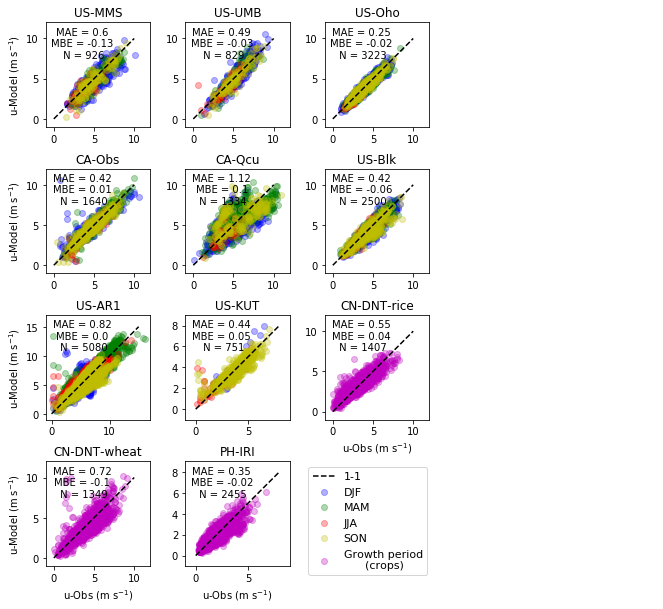

In [22]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']



fig,axs=plt.subplots(4,3,figsize=(15,10))
plt.subplots_adjust(hspace=.4,wspace=-.75)
# ratio_z0=[]
# ratio_d=[]
colors=['b','g','r','y']
for i,name in enumerate(names):
    #print(name)
    MAE_all=[]
    MBE_all=[]
    number_all=0
    ax=axs[int(np.floor((i)/3))][int(i-3*(np.floor((i)/3)))]
    if name not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']: 
    
        for season,color in zip(['DJF','MAM','JJA','SON'],colors):

            try:
                z0=res[name][season]['z0']
                d=res[name][season]['d']
                h_sfc=res[name][season]['h_sfc']
                ser_ws=res[name][season]['ws_obs']
                ws_mod=res[name][season]['ws_mod']
                MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
                MBE_all.append(np.mean(ws_mod-ser_ws))
                number_all+=len(ws_mod)
        #         ratio_z0.append(z0/h_sfc)
        #         ratio_d.append(d/h_sfc)
                ax.scatter(ser_ws,ws_mod,color=color,alpha=0.3)
            except:
                pass
    else:
        z0=res[name]['z0']
        d=res[name]['d']
        h_sfc=res[name]['h_sfc']
        ser_ws=res[name]['ws_obs']
        ws_mod=res[name]['ws_mod']
        MAE_all.append(np.mean(abs(ws_mod-ser_ws)))
        MBE_all.append(np.mean(ws_mod-ser_ws))
        number_all+=len(ws_mod)
#         ratio_z0.append(z0/h_sfc)
#         ratio_d.append(d/h_sfc)
        ax.scatter(ser_ws,ws_mod,color='m',alpha=0.3)
    
    text1=f'MAE = {np.round(np.mean(MAE_all),2)}\nMBE = {np.round(np.mean(MBE_all),2)}\n N = {number_all}'
    ax.text(0.35, 0.8,text1, ha='center', va='center',color='k', transform=ax.transAxes,
            bbox=dict(facecolor='none', edgecolor='none',alpha=0.1))
    
    ax.set_ylim([-1,12])
    ax.set_xlim([-1,12])
    
    if name =='US-AR1':
        ax.plot([0,15],[0,15],c='k',linestyle='--')
        ax.set_ylim([-1,17])
        ax.set_xlim([-1,17])
    elif name in ['PH-IRI','US-KUT']:
        ax.plot([0,8],[0,8],c='k',linestyle='--')
        ax.set_ylim([-1,9])
        ax.set_xlim([-1,9])
    else:
        ax.plot([0,10],[0,10],c='k',linestyle='--')
        
    
    if name in ['CN-DNT-wheat','PH-IRI','CN-DNT-rice']:
        ax.set_xlabel('u-Obs (m s$^{-1}$)' )
    if name in ['US-MMS','CA-Obs','US-AR1','CN-DNT-wheat',]:
        ax.set_ylabel('u-Model (m s$^{-1}$)')
    
    #ax.set_title(name+'  (z$_{0m}$='+str(np.round(z0,2))+', z$_d$='+str(np.round(d,2))+', h$_v$='+str(h_sfc)+')')
    ax.set_title(name)
    x0, x1 = ax.get_xlim()
    y0, y1 = ax.get_ylim()
    ax.set_aspect(abs(x1 - x0) / abs(y1 - y0))
    
    if name=='US-MMS':
        ax.scatter([],[],color='m',alpha=0.3)
        ax.legend(['1-1','DJF','MAM','JJA','SON','Growth period\n      (crops)'],bbox_to_anchor=(3.7, -3.2),fontsize=11)
    
axs[3][2].axis('off')
plt.savefig('WS_obs_mod.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

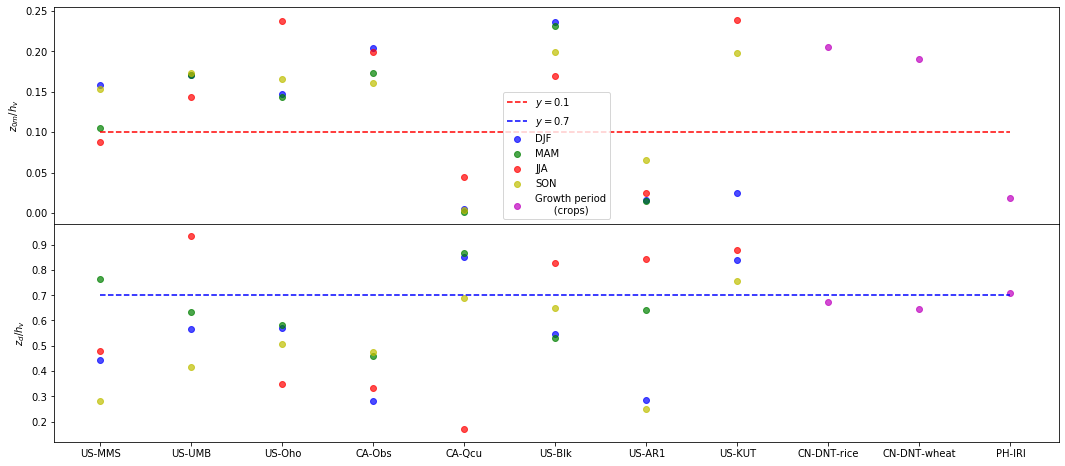

In [23]:
names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
       'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']

colors=['b','g','r','y']

df=pd.DataFrame(columns=['z$_{0m}$ (DJF)','z$_{d}$ (DJF)',
                         'z$_{0m}$ (MAM)','z$_{d}$ (MAM)',
                         'z$_{0m}$ (JJA)','z$_{d}$ (JJA)',
                         'z$_{0m}$ (SON)','z$_{d}$ (SON)',
                         'z$_{0m}$ (Crop)','z$_{d}$ (Crop)',
                        ])

fig,axs=plt.subplots(2,1,figsize=(18,8))
plt.subplots_adjust(hspace=0.0)
ax=axs[0]

all_data={}

for name in names:
    all_data[name]={}
    if name not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        for season,color in zip(['DJF','MAM','JJA','SON'],colors):
            all_data[name][season]={}
            try:
                r_z=np.median(res[name][season]['z0s'])/np.median(res[name][season]['h_sfc'])
                all_data[name][season]['$z_0$']=np.round(np.median(res[name][season]['z0s']),2)
                all_data[name][season]['$z_d$']=np.round(np.median(res[name][season]['ds']),2)
                if name=='US-MMS':
                    ax.scatter(name,r_z,color=color,label=season,alpha=0.7)
                else:
                    ax.scatter(name,r_z,color=color,alpha=0.7)
            except:
                pass
    else:
        all_data[name]['Growth']={}
        r_z=np.median(res[name]['z0s'])/np.median(res[name]['h_sfc'])
        all_data[name]['Growth']['$z_0$']=np.round(np.median(res[name]['z0s']),2)
        all_data[name]['Growth']['$z_d$']=np.round(np.median(res[name]['ds']),2)
        if name=='PH-IRI':
            ax.scatter(name,r_z,color='m',label='Growth period\n      (crops)',alpha=0.7) 
        else:
            ax.scatter(name,r_z,color='m',alpha=0.7)


ax.plot([0,10],[0.1,0.1],color='r',linestyle='--',label='$y=0.1$')
ax.plot([],[],color='b',linestyle='--',label='$y=0.7$')
ax.set_ylabel('$z_{0m}/h_v$')
ax.legend()
ax.axes.get_xaxis().set_visible(False)

ax=axs[1]

for name in names:
    if name not in ['CN-DNT-rice','CN-DNT-wheat','PH-IRI']:
        for season,color in zip(['DJF','MAM','JJA','SON'],colors):
            try:
                r_z=np.median(res[name][season]['ds'])/np.median(res[name][season]['h_sfc'])
                if name=='US-MMS':
                    ax.scatter(name,r_z,color=color,label=season,alpha=0.7)
                else:
                    ax.scatter(name,r_z,color=color,alpha=0.7)
            except:
                pass
    else:
        r_z=np.median(res[name]['ds'])/np.median(res[name]['h_sfc'])
        if name=='PH-IRI':
            ax.scatter(name,r_z,color='m',label='Growth period\n      (crops)',alpha=0.7) 
        else:
            ax.scatter(name,r_z,color='m',alpha=0.7)


ax.plot([0,10],[0.7,0.7],color='b',linestyle='--',label='$y=0.7$')
ax.set_ylabel('$z_{d}/h_v$')

plt.savefig('z0_d.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [24]:
pd.DataFrame.from_dict(all_data)

,US-MMS,US-UMB,US-Oho,CA-Obs,CA-Qcu,US-Blk,US-AR1,US-KUT,CN-DNT-rice,CN-DNT-wheat,PH-IRI
DJF,"{'$z_0$': 3.95, '$z_d$': 11.13}","{'$z_0$': 3.41, '$z_d$': 11.3}","{'$z_0$': 3.52, '$z_d$': 13.67}","{'$z_0$': 1.47, '$z_d$': 2.01}","{'$z_0$': 0.07, '$z_d$': 11.74}","{'$z_0$': 3.07, '$z_d$': 7.11}","{'$z_0$': 0.02, '$z_d$': 0.28}","{'$z_0$': 0.0, '$z_d$': 0.06}",NaN,NaN,NaN
MAM,"{'$z_0$': 2.63, '$z_d$': 19.09}","{'$z_0$': 3.42, '$z_d$': 12.7}","{'$z_0$': 3.45, '$z_d$': 13.97}","{'$z_0$': 1.24, '$z_d$': 3.32}","{'$z_0$': 0.02, '$z_d$': 11.96}","{'$z_0$': 3.0, '$z_d$': 6.88}","{'$z_0$': 0.01, '$z_d$': 0.64}",{},NaN,NaN,NaN
JJA,"{'$z_0$': 2.2, '$z_d$': 12.02}","{'$z_0$': 2.87, '$z_d$': 18.67}","{'$z_0$': 5.69, '$z_d$': 8.39}","{'$z_0$': 1.43, '$z_d$': 2.38}","{'$z_0$': 0.62, '$z_d$': 2.34}","{'$z_0$': 2.21, '$z_d$': 10.74}","{'$z_0$': 0.02, '$z_d$': 0.84}","{'$z_0$': 0.02, '$z_d$': 0.06}",NaN,NaN,NaN
SON,"{'$z_0$': 3.83, '$z_d$': 7.07}","{'$z_0$': 3.45, '$z_d$': 8.3}","{'$z_0$': 3.97, '$z_d$': 12.2}","{'$z_0$': 1.16, '$z_d$': 3.42}","{'$z_0$': 0.05, '$z_d$': 9.5}","{'$z_0$': 2.59, '$z_d$': 8.44}","{'$z_0$': 0.07, '$z_d$': 0.25}","{'$z_0$': 0.01, '$z_d$': 0.05}",NaN,NaN,NaN
Growth,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'$z_0$': 0.13, '$z_d$': 0.42}","{'$z_0$': 0.11, '$z_d$': 0.37}","{'$z_0$': 0.02, '$z_d$': 0.71}"


In [202]:
# plt.rcParams.update({'font.size': 12})
# fig,ax=plt.subplots(1,1,figsize=(18,4))


# ax.scatter(names,ratio_z0,c='b',label='$z_{0m}/h_v$')
# ax.plot(names,[.1 for x in names],color='b',linestyle='--',label='$y=0.1$')



# ax.scatter(names,ratio_d,c='r',marker='x',label='$z_d/h_v$')
# ax.plot(names,[.7 for x in names],color='r',linestyle='--',label='$y=0.7$')

# ax.legend()

# plt.savefig('z0_d.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)

In [203]:
# names=['US-MMS','US-UMB','US-Oho','CA-Obs','CA-Qcu',
#        'US-Blk','US-AR1','US-KUT','CN-DNT-rice','CN-DNT-wheat','PH-IRI']

# all_z0=[]
# all_d=[]

# plt.rcParams.update({'font.size': 12})
# fig,axs=plt.subplots(2,1,figsize=(18,7))
# plt.subplots_adjust(hspace=0.03)
# for name in names:
#     h_sfc=res[name]['h_sfc'] 
#     all_z0.append(res[name]['z0s']/h_sfc)
#     all_d.append(res[name]['ds']/h_sfc)


# ax=axs[0]
# ax.boxplot(all_z0,showfliers=False)
# ax.plot([x+1 for x in range(len(names))],[.1 for x in names],color='b',linestyle='--',label='$y=0.1$')  
# ax.set_ylabel('$z_{0m}/h_v$')
# ax.legend()  
# ax.axes.get_xaxis().set_visible(False)

# ax=axs[1]
# ax.boxplot(all_d,showfliers=False)
# ax.plot([x+1 for x in range(len(names))],[.7 for x in names],color='r',linestyle='--',label='$y=0.7$')
# ax.set_ylabel('$z_{d}/h_v$')
# txt=ax.set_xticklabels([x for x in names])
# ax.legend() 
# plt.savefig('z0_d_box.png',dpi=300,bbox_inches = 'tight',pad_inches = 0.01)